## AUTOGRAD (자동미분)
- autograd 패키지는 Tensor의 모든 연산에 대해 **자동 미분** 제공

- 이는 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 뜻

- backprop를 위한 미분값을 자동으로 계산

### Tensor

- data: tensor형태의 데이터

- grad: data가 겨쳐온 layer에 대한 미분값 저장

- grad_fn: 미분값을 계산한 함수에 대한 정보 저장 (어떤 함수에 대해서 backprop 했는지)

- `requires_grad` 속성을 `True`로 설정하면, 해당 텐서에서 이루어지는 모든 연산들을 추적하기 시작

- 계산이 완료된 후, `.backward()`를 호출하면 자동으로 `gradient`를 계산할 수 있으며, `.grad` 속성에 누적됨

- 기록을 추적하는 것을 중단하게 하려면, `.detach()`를 호출하여 연산기록으로부터 분리

- 기록을 추적하는 것을 방지하기 위해 코드 블럭을 `with torch.no_grad():`로 감싸면 `gradient`는 필요없지만, `requires_grad=True`로 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용

- Autograd 구현에서 매우 중요한 클래스 : `Function` 클래스

In [1]:
import torch

In [43]:
x = torch.ones(3, 3, requires_grad=True)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)


In [44]:
y = x + 5
print(y) #backward붙는다

tensor([[6., 6., 6.],
        [6., 6., 6.],
        [6., 6., 6.]], grad_fn=<AddBackward0>)


In [45]:
print(y.grad_fn)

In [46]:
z = y * y * 2
out = z.mean()
print(z, out) #곱에대한 backward가 붙는다.

tensor([[72., 72., 72.],
        [72., 72., 72.],
        [72., 72., 72.]], grad_fn=<MulBackward0>) tensor(72., grad_fn=<MeanBackward0>)


- `requires_grad_(...)`는 기존 텐서의 `requires_grad`값을 바꿔치기(`in-place`)하여 변경

In [47]:
a = torch.randn(3,3)
a = ((a * 3) / (a - 1))
print(a.requires_grad)

a.requires_grad_(True)
print(a.requires_grad)

b = (a*a).sum() 
print(b.grad_fn) 
##계산을 추척한다 

False
True


### 기울기(Gradient)
- 역전파: `.backward()`를 통해 역전파 계산 가능

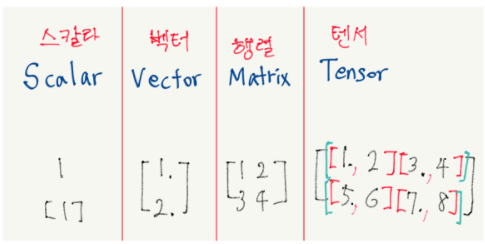

In [48]:
out.backward()

In [49]:
print(x.grad)

tensor([[2.6667, 2.6667, 2.6667],
        [2.6667, 2.6667, 2.6667],
        [2.6667, 2.6667, 2.6667]])


In [50]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000: #1000미만일떄까지
  y = y * 2

print(y)

tensor([-844.0374, -840.5577, -717.7084], grad_fn=<MulBackward0>)


In [51]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype = torch.float)
y.backward(v) #v에대한 y의 기울기

print(x.grad)

tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])


- `with torch.no_grad()`를 사용하여 gradient의 업데이트를 하지 않음

In [52]:
print(x.requires_grad)
print((x**2).requires_grad)

with torch.no_grad():
  print((x **2).requires_grad)

True
True
False


- `detach()`: 내용물(content)은 같지만 require_grad가 다른 새로운 Tensor를 가져올 때

In [54]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all()) #x,y 값 서로 같은지확인-->같음

True
False
tensor(True)


### 자동 미분 흐름 다시 보기(1)
- 계산 흐름  
  $a \rightarrow b  \rightarrow c  \rightarrow out $

<br>

## $\quad \frac{\partial out}{\partial a} = ?$
- `backward()`를 통해  
  $a \leftarrow b  \leftarrow c  \leftarrow out $을 계산하면  
    $\frac{\partial out}{\partial a}$값이 `a.grad`에 채워짐


In [55]:
a = torch.ones(2,2)
print(a)

tensor([[1., 1.],
        [1., 1.]])


In [56]:
a = torch.ones(2,2,requires_grad=True)
print(a)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [58]:
print('a.data:', a)
print('a.grad', a.grad)
print('a.grad_fn', a.grad_fn)

a.data: tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
a.grad None
a.grad_fn None


- $b = a + 2$

In [59]:
b = a + 2
print(b)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


- $c = b^2$ 

In [60]:
c = b ** 2
print(c)

tensor([[9., 9.],
        [9., 9.]], grad_fn=<PowBackward0>)


In [61]:
out = c.sum()
print(out)

tensor(36., grad_fn=<SumBackward0>)


In [62]:
print(out)
out.backward()

tensor(36., grad_fn=<SumBackward0>)


- a의 `grad_fn`이 None인 이유  
  직접적으로 계산한 부분이 없었기 때문

In [64]:
print('a.data:', a.data)
print('a.grad', a.grad)
print('a.grad_fn', a.grad_fn)

a.data: tensor([[1., 1.],
        [1., 1.]])
a.grad tensor([[6., 6.],
        [6., 6.]])
a.grad_fn None


In [65]:
print('b.data:', b.data)
print('b.grad', b.grad)
print('b.grad_fn', b.grad_fn)

b.data: tensor([[3., 3.],
        [3., 3.]])
b.grad None
b.grad_fn <AddBackward0 object at 0x7f5b18fed410>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [66]:
print('c.data:', c.data)
print('c.grad', c.grad)
print('c.grad_fn', c.grad_fn)

c.data: tensor([[9., 9.],
        [9., 9.]])
c.grad None
c.grad_fn <PowBackward0 object at 0x7f5b19080d90>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [67]:
print('out.data:', out.data)
print('out.grad', out.grad)
print('out.grad_fn', out.grad_fn)

out.data: tensor(36.)
out.grad None
out.grad_fn <SumBackward0 object at 0x7f5b217dbe50>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


### 자동 미분 흐름 다시 보기(2)
- `grad`값을 넣어서 `backward`

- 아래의 코드에서 `.grad`값이 None은 gradient값이 필요하지 않기 때문

In [68]:
x = torch.ones(3, requires_grad=True)
y = x ** 2
z = y ** 2 + x
out = z.sum()
print(out)

tensor(6., grad_fn=<SumBackward0>)


In [69]:
grad = torch.Tensor([0.1, 1, 100])
z.backward(grad)

In [70]:
print('x.data:', x.data)
print('x.grad', x.grad)
print('x.grad_fn', x.grad_fn)

x.data: tensor([1., 1., 1.])
x.grad tensor([  0.5000,   5.0000, 500.0000])
x.grad_fn None


In [71]:
print('y.data:', y.data)
print('y.grad', y.grad)
print('y.grad_fn', y.grad_fn)

y.data: tensor([1., 1., 1.])
y.grad None
y.grad_fn <PowBackward0 object at 0x7f5b217b9d10>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [73]:
print('z.data:', z.data)
print('z.grad', z.grad)
print('z.grad_fn', z.grad_fn)

z.data: tensor([2., 2., 2.])
z.grad None
z.grad_fn <AddBackward0 object at 0x7f5b1900b310>


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad
